<a href="https://colab.research.google.com/github/eskayML/lelapa-assessment/blob/main/LELAPA%20SUBMISSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1lp56-xMz770ZNDfrC5kkyJHbJ8YrR8pQ # 'I'M DOWNLOADING THE DATA DIRECTLY FROM THE GOOGLE DRIVE LINK THAT WAS SHARED WITH ME
!unzip -qq dataset_v2.zip

Downloading...
From: https://drive.google.com/uc?id=1lp56-xMz770ZNDfrC5kkyJHbJ8YrR8pQ
To: /content/dataset_v2.zip
100% 6.27M/6.27M [00:00<00:00, 15.0MB/s]


In [2]:

!pip install jiwer evaluate  -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.2 MB/s eta 0:00:00


# TASK 1 -  EXPLORATORY DATA ANALYSIS (EDA)

In [3]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import librosa
from tqdm.notebook import tqdm
import torchaudio
import torch
import time
from datasets import Audio
from transformers import pipeline, Wav2Vec2Processor, Wav2Vec2ForCTC
import jiwer
from jiwer import wer, cer
import soundfile as sf
import re
from difflib import SequenceMatcher
import ipywidgets as widgets
from IPython.display import display, HTML



import warnings
warnings.filterwarnings('ignore')

dataset_path = 'dataset_v2'
transcriptions_file = os.path.join(dataset_path, 'transcriptions.csv')

np.random.seed(42)


df = pd.read_csv(transcriptions_file)

# convert audio duration to seconds
df['duration_seconds'] = df['duration'] / 1000.0

# correcting the audio path
df['audio_paths'] = df['audio_paths'].str.replace("./audios", dataset_path)

print("Dataset Info:")
display(df.info())
print("\nSample Data:")
display(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   idx               97 non-null     int64  
 1   user_ids          97 non-null     object 
 2   accent            97 non-null     object 
 3   country           97 non-null     object 
 4   transcript        97 non-null     object 
 5   nchars            97 non-null     int64  
 6   audio_ids         97 non-null     object 
 7   audio_paths       97 non-null     object 
 8   duration          97 non-null     float64
 9   origin            97 non-null     object 
 10  domain            97 non-null     object 
 11  gender            97 non-null     object 
 12  duration_seconds  97 non-null     float64
dtypes: float64(2), int64(2), object(9)
memory usage: 10.0+ KB


None


Sample Data:


,idx,user_ids,accent,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,gender,duration_seconds
0,7252,AKHONA,eng_sot,ZA,well. e tlo. depend. -a ka di. sales. tsa hau.,46,AKHONA_12-11-02_237.wav,dataset_v2/AKHONA_12-11-02_237.wav,1436.0,african,soap_opera,female,1.436
1,15425,AKHONA,eng_sot,ZA,k'o omantse. poor abel. neh.,28,AKHONA_12-11-09_140.wav,dataset_v2/AKHONA_12-11-09_140.wav,1245.0,african,soap_opera,female,1.245
2,21333,AKHONA,eng_sot,ZA,well. ha re na di. railing so.,30,AKHONA_12-12-13_30.wav,dataset_v2/AKHONA_12-12-13_30.wav,1643.0,african,soap_opera,female,1.643
3,4314,AKHONA,eng_sot,ZA,hopefully. tla be e le. live by next week.,42,AKHONA_139_7.wav,dataset_v2/AKHONA_139_7.wav,2151.0,african,soap_opera,female,2.151
4,18443,CALEB,eng_sot,ZA,o. alright.,11,CALEB_100_239.wav,dataset_v2/CALEB_100_239.wav,660.0,african,soap_opera,male,0.660


In [4]:
df.describe()

,idx,nchars,duration,duration_seconds
count,97.000000,97.000000,97.000000,97.000000
mean,35301.639175,45.463918,2083.721649,2.083722
std,20051.008555,23.005462,1062.260529,1.062261
min,380.000000,11.000000,660.000000,0.660000
25%,19462.000000,32.000000,1297.000000,1.297000
50%,34888.000000,42.000000,1760.000000,1.760000
75%,54356.000000,51.000000,2584.000000,2.584000
max,63974.000000,153.000000,6340.000000,6.340000


In [5]:
df.isnull().sum()

,0
idx,0
user_ids,0
accent,0
country,0
transcript,0
nchars,0
audio_ids,0
audio_paths,0
duration,0
origin,0


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.nunique()

,0
idx,97
user_ids,19
accent,1
country,1
transcript,96
nchars,58
audio_ids,97
audio_paths,97
duration,96
origin,1


Text(0.5, 1.0, 'count of user ids')

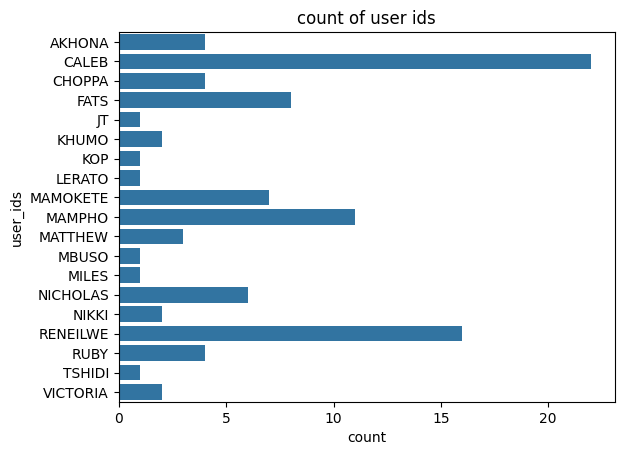

In [8]:
sns.countplot(y='user_ids', data = df )
plt.title("count of user ids")

<Axes: xlabel='gender', ylabel='count'>

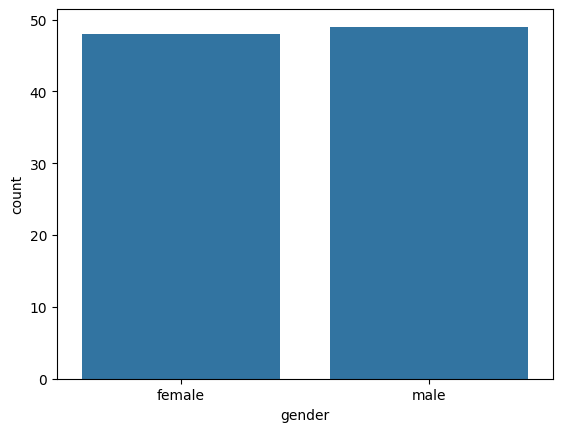

In [9]:
sns.countplot(x = 'gender', data = df)

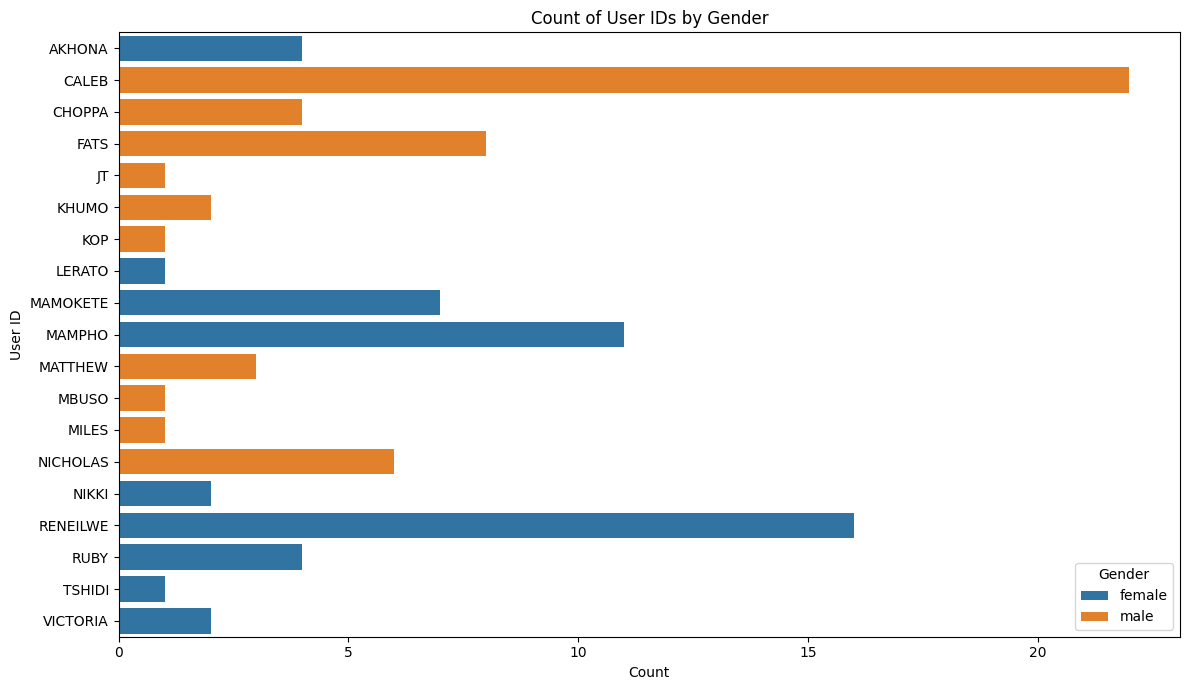

In [10]:
plt.figure(figsize=(12, 7)) # Adjust figure size for better readability if many user_ids
sns.countplot(y='user_ids', hue='gender', data=df, palette='tab10')
plt.title('Count of User IDs by Gender')
plt.ylabel('User ID')
plt.xlabel('Count')

plt.legend(title='Gender')
plt.tight_layout()
plt.show()

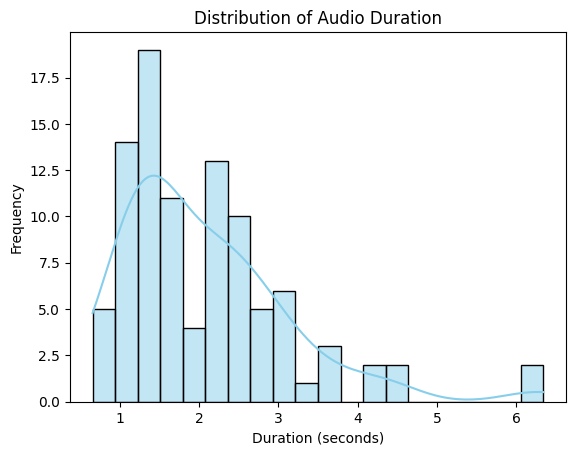

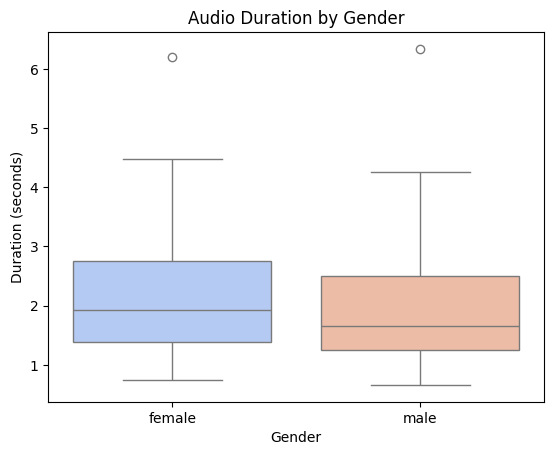

In [11]:
plt.figure()
sns.histplot(df['duration_seconds'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Audio Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


plt.figure()
sns.boxplot(x='gender', y='duration_seconds', data=df, palette='coolwarm')
plt.title('Audio Duration by Gender')
plt.xlabel('Gender')
plt.ylabel('Duration (seconds)')
plt.show()

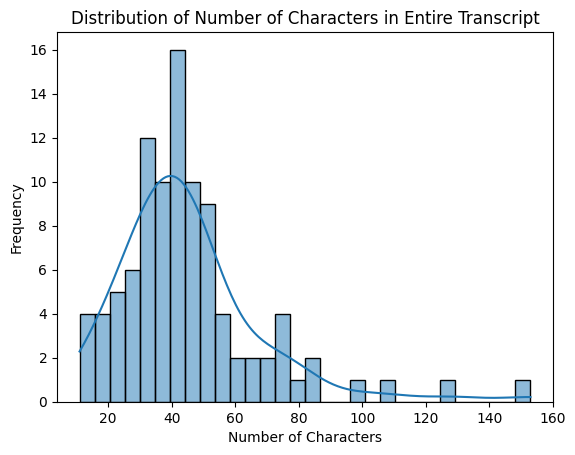

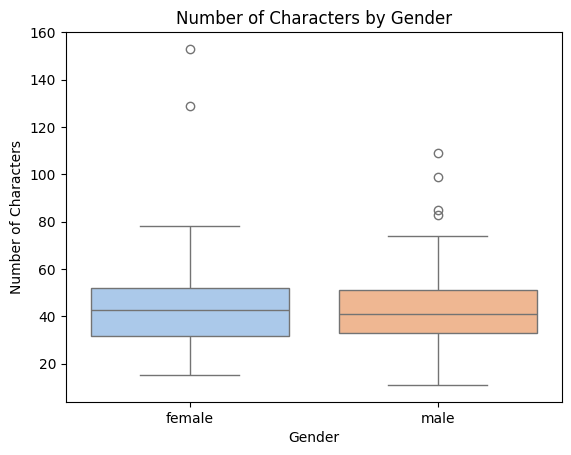

In [12]:
plt.figure()
sns.histplot(df['nchars'], bins=30, kde=True)
plt.title('Distribution of Number of Characters in Entire Transcript')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

plt.figure()
sns.boxplot(x='gender', y='nchars', data=df, palette='pastel')
plt.title('Number of Characters by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Characters')
plt.show()

SHOWING WORD CLOUD FOR MALE TRANSCRIPTS


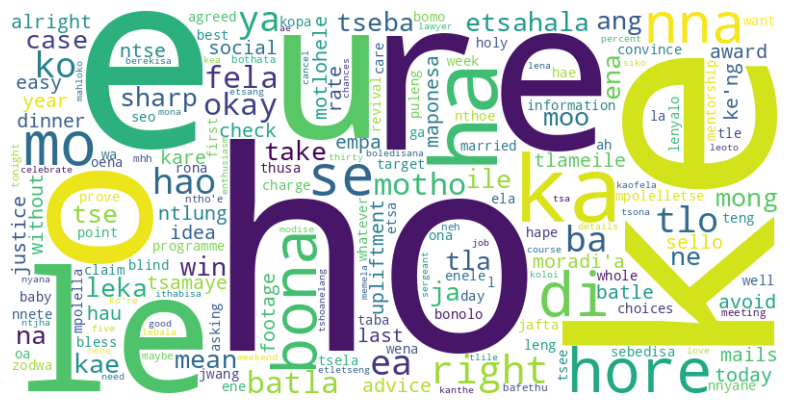

SHOWING WORD CLOUD FOR FEMALE TRANSCRIPTS


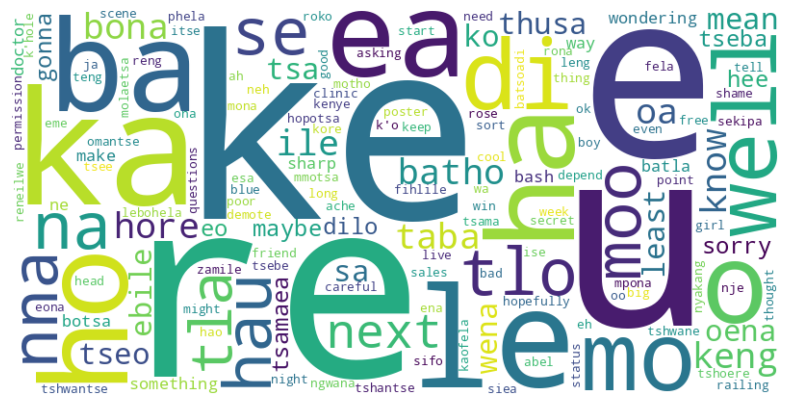

In [13]:
from wordcloud import WordCloud, STOPWORDS

# Combine all transcripts for male gender
male_transcripts = " ".join(df[df['gender'] == 'male']['transcript'].dropna().astype(str))

female_transcripts = " ".join(df[df['gender'] == 'female']['transcript'].dropna().astype(str))


print("SHOWING WORD CLOUD FOR MALE TRANSCRIPTS")
# Generate word cloud for male transcripts
if male_transcripts:
    wordcloud_male = WordCloud(width=800, height=400,
                               background_color='white',
                               min_font_size=10).generate(male_transcripts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_male, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("No male transcripts found to generate word cloud.")


print("SHOWING WORD CLOUD FOR FEMALE TRANSCRIPTS")
# Generate word cloud for female transcripts
if female_transcripts:
    wordcloud_female = WordCloud(width=800, height=400,
                                 background_color='white',
                                 min_font_size=10).generate(female_transcripts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_female, interpolation='bilinear')

    plt.axis('off')
    plt.show()
else:
    print("No female transcripts found to generate word cloud.")



<Figure size 640x480 with 0 Axes>

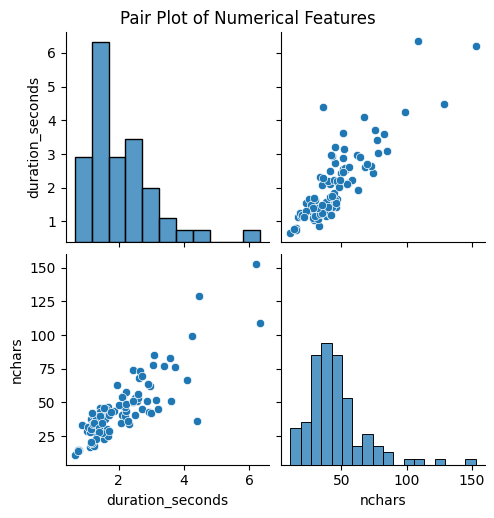

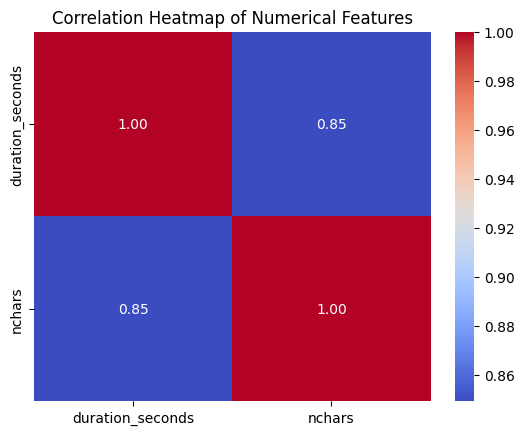

In [14]:
numerical_cols = ['duration_seconds', 'nchars']
if all(col in df.columns for col in numerical_cols):
    plt.figure()
    sns.pairplot(df[numerical_cols])
    plt.suptitle('Pair Plot of Numerical Features', y=1.02)
    plt.show()


if all(col in df.columns for col in numerical_cols):
    plt.figure()
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()


**Summary of My findings from the EDA**



*   The dataset contains 97 audio recordings with associated transcriptions.
*   There are 19 unique user IDs in the dataset.
*   The dataset appears to be focused on a single accent (`eng_sot`), country (`ZA`), origin (`african`), and domain (`soap_opera`), indicating it's quite specific.
*   There are 2 distinct genders represented in the dataset.
*   The number of audio files and transcripts are the same (97),  which signifies to us that there is a one-to-one mapping between audio and transcription.
*   The average audio duration is approximately 2.08 seconds, with a maximum duration of 6.34 seconds.
*   The average number of characters in a transcript is about 45.46, with a maximum of 153 characters.
*   There are no missing values in the dataset.
*   The distribution of audio durations and the number of characters in transcripts are visualized, showing their spread.
*   I added some Word clouds for male and female transcripts show the most frequent words used by each gender in the dataset.
*   The distribution of user IDs shows variability in the number of recordings per user.
*   The gender distribution shows the proportion of recordings from male and female speakers.
*   Analyzing the count of User IDs by Gender reveals which users contributed more recordings and their respective genders.
*   There is a strong positive correlation (0.85) between audio duration and the number of characters in the transcript, which is expected as longer audio generally corresponds to more words (and thus characters).

# TASK2 -  EXPLORATORY MODEL ANALYSIS (EMA)

In [15]:

whisper_asr = pipeline("automatic-speech-recognition", model="openai/whisper-small")

# Load Wav2Vec2 model and processor
wav2vec2_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec2_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

def run_whisper_benchmark(df, whisper_asr):
    """
    Benchmarks Whisper-Small model on the provided DataFrame.
    Calculates WER, CER, and latency without capping error rates.
    """
    results = []
    print("Benchmarking Whisper-Small...")
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Whisper-Small Progress"):
        audio_path = row['audio_paths']
        ground_truth = row['transcript']

        whisper_prediction = ""
        latency = 0.0

        try:
            start_time = time.perf_counter()
            whisper_prediction = whisper_asr(audio_path)["text"]
            end_time = time.perf_counter()
            latency = end_time - start_time

            wer_score = wer(ground_truth.lower(), whisper_prediction.lower())
            cer_score = cer(ground_truth.lower(), whisper_prediction.lower())

        except Exception as e:
            print(f"Error processing {audio_path} with Whisper: {e}")

            latency = 0.0
            wer_score = 1
            cer_score = 1

        results.append({
            'ground_truth': ground_truth.lower(),
            'prediction': whisper_prediction.lower(),
            'wer': wer_score,
            'cer': cer_score,
            'latency_ms': latency * 1000 # Convert to milliseconds
        })
    return pd.DataFrame(results)

def run_wav2vec2_benchmark(df, wav2vec2_model, wav2vec2_processor):
    """
    Benchmarks Wav2Vec2 model on the provided DataFrame.
    Calculates WER, CER, and latency without capping error rates.
    """
    results = []
    print("\nBenchmarking Wav2Vec2...")
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Wav2Vec2 Progress"):
        audio_path = row['audio_paths']
        ground_truth = row['transcript']

        transcription = ""

        latency = 0.0

        try:
            start_time = time.perf_counter()
            speech_array, sampling_rate = torchaudio.load(audio_path)
            # Ensure the audio is mono by taking the first channel if it's stereo
            if speech_array.shape[0] > 1:
                speech_array = speech_array[0, :].unsqueeze(0)
            resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
            speech_array = resampler(speech_array).squeeze(0)

            input_values = wav2vec2_processor(speech_array, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
            logits = wav2vec2_model(input_values).logits
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = wav2vec2_processor.batch_decode(predicted_ids)[0]
            end_time = time.perf_counter()
            latency = end_time - start_time

            wer_score = wer(ground_truth.lower(), transcription.lower())
            cer_score = cer(ground_truth.lower(), transcription.lower())

        except Exception as e:
            print(f"Error processing {audio_path} with Wav2Vec2: {e}")
            latency = 0.0
            wer_score = 1
            cer_score = 1


        results.append({
            'ground_truth': ground_truth.lower(),
            'prediction': transcription.lower(),
            'wer': wer_score,
            'cer': cer_score,
            'latency_ms': latency * 1000 # Convert to milliseconds
        })
    return pd.DataFrame(results)

# Run benchmarks
whisper_df = run_whisper_benchmark(df, whisper_asr)
display(whisper_df)

# Calculate means, handling NaN values
avg_wer_whisper = whisper_df['wer'].mean()
avg_cer_whisper = whisper_df['cer'].mean()
avg_latency_whisper = whisper_df['latency_ms'].mean()

print(f"\nAverage WER for Whisper-Small: {avg_wer_whisper:.4f}")
print(f"Average CER for Whisper-Small: {avg_cer_whisper:.4f}")
print(f"Average Latency for Whisper-Small: {avg_latency_whisper:.2f} ms")


wav2vec2_df = run_wav2vec2_benchmark(df, wav2vec2_model, wav2vec2_processor)
display(wav2vec2_df)

# Calculate means, handling NaN values
avg_wer_wav2vec2 = wav2vec2_df['wer'].mean()
avg_cer_wav2vec2 = wav2vec2_df['cer'].mean()
avg_latency_wav2vec2 = wav2vec2_df['latency_ms'].mean()

print(f"\nAverage WER for Wav2Vec2: {avg_wer_wav2vec2:.4f}")
print(f"Average CER for Wav2Vec2: {avg_cer_wav2vec2:.4f}")
print(f"Average Latency for Wav2Vec2: {avg_latency_wav2vec2:.2f} ms")

# Create a comparison table
comparison_data = [
    ["Whisper-Small", f"{avg_wer_whisper:.4f}", f"{avg_cer_whisper:.4f}", f"{avg_latency_whisper:.2f} ms"],
    ["Wav2Vec2", f"{avg_wer_wav2vec2:.4f}", f"{avg_cer_wav2vec2:.4f}", f"{avg_latency_wav2vec2:.2f} ms"]
]

headers = ["Model", "Average WER", "Average CER", "Average Latency"]

print("\n--- Model Benchmarking Comparison ---")
comparison_df = pd.DataFrame(comparison_data, columns=headers)
display(comparison_df)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Benchmarking Whisper-Small...


Whisper-Small Progress:   0%|          | 0/97 [00:00<?, ?it/s]

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,ground_truth,prediction,wer,cer,latency_ms
0,well. e tlo. depend. -a ka di. sales. tsa hau.,what if we depend on data sales to help?,1.000000,0.543478,2592.256503
1,k'o omantse. poor abel. neh.,검은색 폴 앨범에,1.000000,0.928571,634.489689
2,well. ha re na di. railing so.,"well, i'm not railing, so...",1.000000,0.466667,617.888680
3,hopefully. tla be e le. live by next week.,hopefully the other live by next week.,0.555556,0.214286,602.017510
4,o. alright.,all right.,1.000000,0.454545,471.753730
...,...,...,...,...,...
92,you can do all the healing you want. u ntse u....,you can do all the healing you want.,0.428571,0.437500,803.961668
93,le nna ke. desperate.,linna gidesparit.,1.000000,0.428571,606.123796
94,o tlo ba. doctor. ka mo o a tsuba le di kwae.,្្្្ ្្្ ្្្ ្្្ ្្្ ្្្ ្្្ ្្្ ្្្ ្្្ ្្្ ...,5.083333,4.377778,10877.762085
95,isn't the doctor. ea moo ntlong moo.,isn't that dr. yamanrungu?,0.857143,0.527778,669.421106



Average WER for Whisper-Small: 1.5886
Average CER for Whisper-Small: 1.3127
Average Latency for Whisper-Small: 2009.36 ms

Benchmarking Wav2Vec2...


Wav2Vec2 Progress:   0%|          | 0/97 [00:00<?, ?it/s]

,ground_truth,prediction,wer,cer,latency_ms
0,well. e tlo. depend. -a ka di. sales. tsa hau.,bal coud up and dare to sale so,1.000000,0.673913,631.417718
1,k'o omantse. poor abel. neh.,gom in to poor abl ner,1.000000,0.500000,336.841184
2,well. ha re na di. railing so.,avn hat a railing so,0.857143,0.466667,388.716513
3,hopefully. tla be e le. live by next week.,hoply tdelly life by next week,0.777778,0.380952,447.422296
4,o. alright.,whit,1.000000,0.818182,212.723051
...,...,...,...,...,...
92,you can do all the healing you want. u ntse u....,you can do all the helling you want on so blun...,0.571429,0.312500,532.012989
93,le nna ke. desperate.,lin laga despite,1.000000,0.571429,270.370318
94,o tlo ba. doctor. ka mo o a tsuba le di kwae.,ol o at alki come all these words wor in guay,1.000000,0.800000,597.804774
95,isn't the doctor. ea moo ntlong moo.,isn't the doctor yamontru,0.714286,0.388889,441.806265



Average WER for Wav2Vec2: 0.9247
Average CER for Wav2Vec2: 0.5788
Average Latency for Wav2Vec2: 445.86 ms

--- Model Benchmarking Comparison ---


,Model,Average WER,Average CER,Average Latency
0,Whisper-Small,1.5886,1.3127,2009.36 ms
1,Wav2Vec2,0.9247,0.5788,445.86 ms


**Justification**

From the results, it is obvious that Wav2vec2 is the better performing model here
- It has the lower avg WER and also the lower avg CER
- It also has the lower avg latency which makes it more desirable since this is for a mobile based transcription service.

**Note:** Assuming that this assessment you gave me allowed for a larger whisper variant (e.g medium, turbo or large-v3) the results might have been different.

# TASK 3 - ERROR ANALYSIS


--- Wav2Vec2 Error Analysis ---


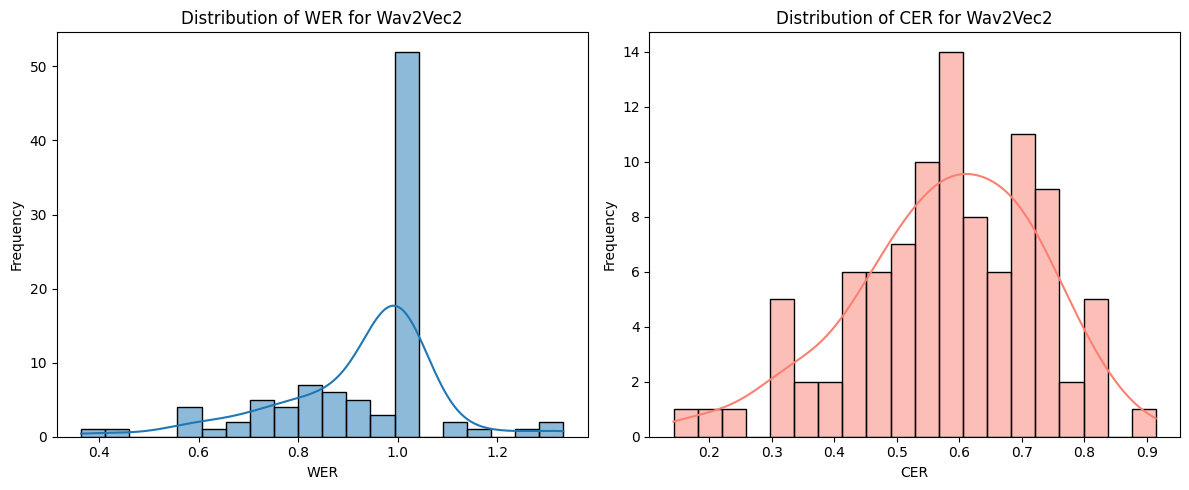

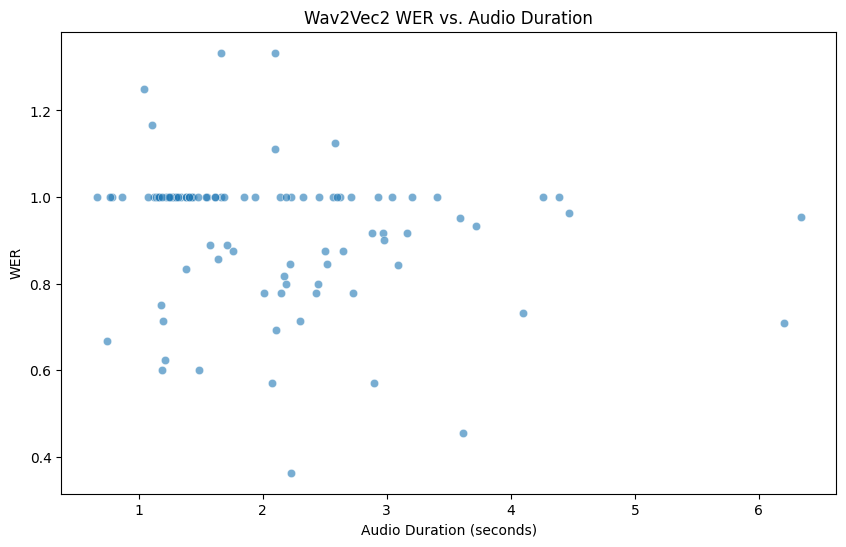

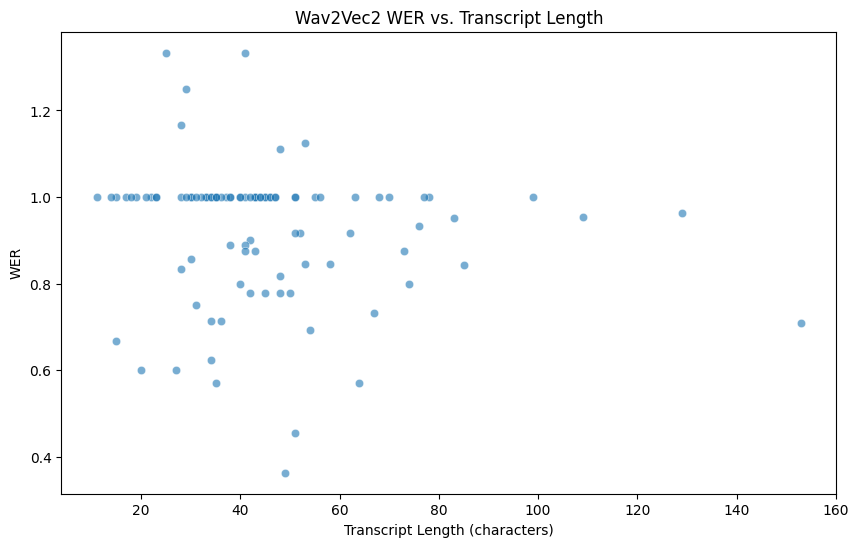

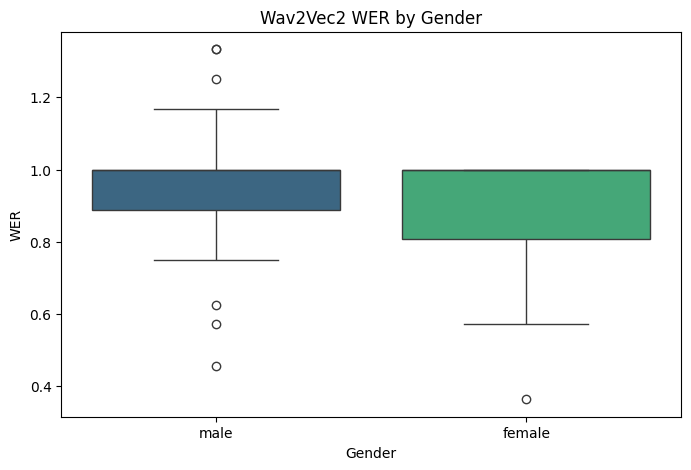

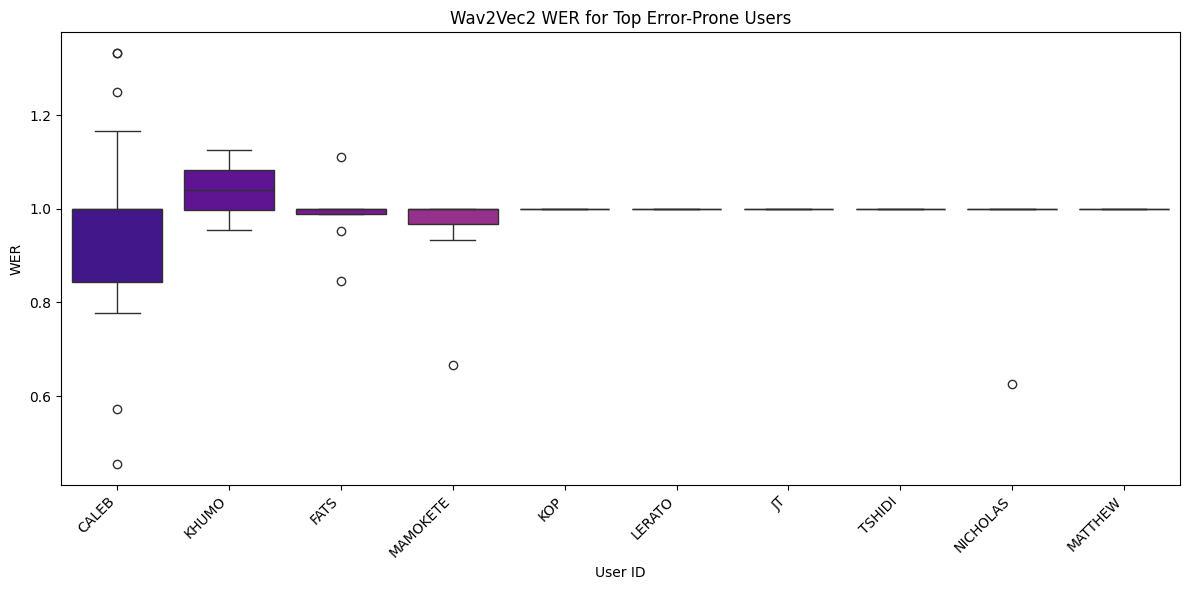


Top 10 High-Error Wav2Vec2 Transcriptions:

--- Case 1 (WER: 1.33) ---
Audio Path: dataset_v2/CALEB_127_285.wav
Original Transcript: well. ho bonolo ho sebedisa. information.
Wav2Vec2 Prediction: but hobban not also vety sake for misya
Diff (Ground Truth [deleted]-><inserted>): [well.]-><but> ho<bban> [bo]no<t a>l<s>o [ho]-><vety> s<ak>e[bedisa.] [in]for< >m<isy>a[tion.]

--- Case 2 (WER: 1.33) ---
Audio Path: dataset_v2/CALEB_146_7.wav
Original Transcript: ena ke ona tsela e. best.
Wav2Vec2 Prediction: en i co on at a la best
Diff (Ground Truth [deleted]-><inserted>): en[a] [ke]-><i co> on< at >a [tse]la[ e.] best[.]

--- Case 3 (WER: 1.25) ---
Audio Path: dataset_v2/CALEB_126_107.wav
Original Transcript: maponesa a mpolelletse. baby.
Wav2Vec2 Prediction: when is sumple in itsavi
Diff (Ground Truth [deleted]-><inserted>): <when is su>m[a]p[o]-><le i>n[e]->< it>sa[ a mpolelletse. baby.]-><vi>

--- Case 4 (WER: 1.17) ---
Audio Path: dataset_v2/CALEB_126_186.wav
Original Transcript: ba 

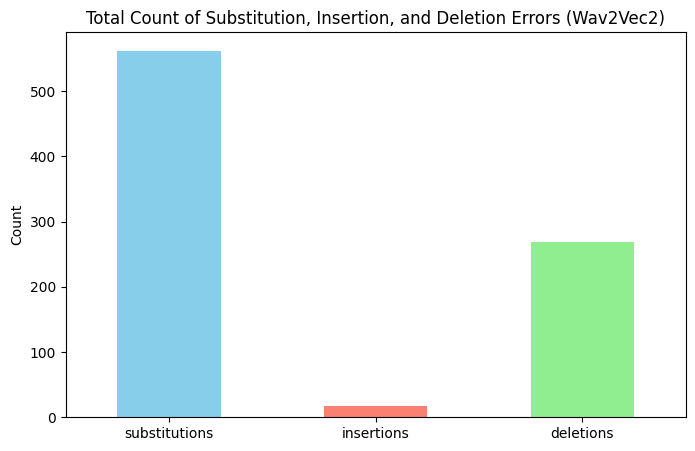

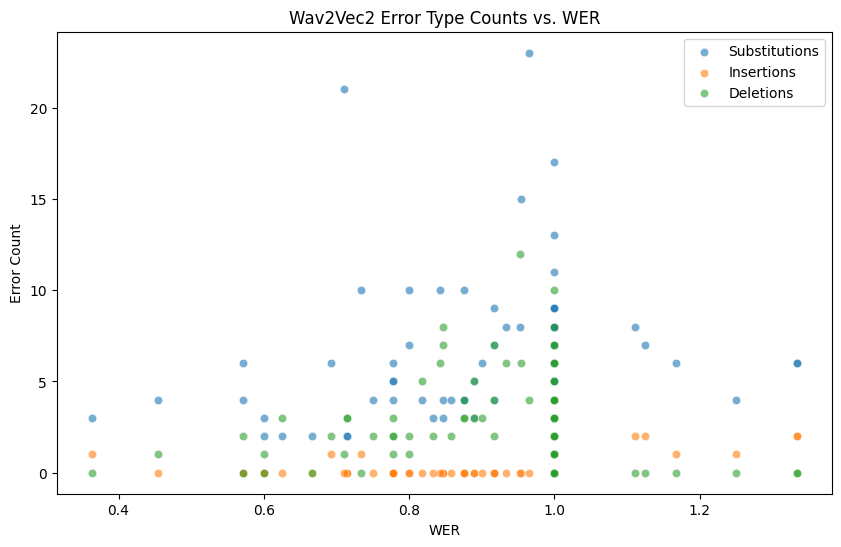

In [16]:



print("\n--- Wav2Vec2 Error Analysis ---")

# Add original audio path and transcript to wav2vec2_df for analysis
wav2vec2_df_analysis = wav2vec2_df.copy()
wav2vec2_df_analysis['audio_paths'] = df['audio_paths']
wav2vec2_df_analysis['original_transcript'] = df['transcript']
wav2vec2_df_analysis['duration_seconds'] = df['duration_seconds']
wav2vec2_df_analysis['nchars'] = df['nchars']
wav2vec2_df_analysis['user_ids'] = df['user_ids']
wav2vec2_df_analysis['gender'] = df['gender']

# Sort by WER for easier analysis of high-error cases
wav2vec2_df_analysis = wav2vec2_df_analysis.sort_values(by='wer', ascending=False).reset_index(drop=True)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(wav2vec2_df_analysis['wer'], bins=20, kde=True)
plt.title('Distribution of WER for Wav2Vec2')
plt.xlabel('WER')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(wav2vec2_df_analysis['cer'], bins=20, kde=True, color='salmon')
plt.title('Distribution of CER for Wav2Vec2')
plt.xlabel('CER')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot Error vs. Audio Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='wer', data=wav2vec2_df_analysis, alpha=0.6)
plt.title('Wav2Vec2 WER vs. Audio Duration')
plt.xlabel('Audio Duration (seconds)')
plt.ylabel('WER')
plt.show()

# Plot Error vs. Transcript Length
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nchars', y='wer', data=wav2vec2_df_analysis, alpha=0.6)
plt.title('Wav2Vec2 WER vs. Transcript Length')
plt.xlabel('Transcript Length (characters)')
plt.ylabel('WER')
plt.show()

# Plot Error by Gender
plt.figure(figsize=(8, 5))
sns.boxplot(x='gender', y='wer', data=wav2vec2_df_analysis, palette='viridis')
plt.title('Wav2Vec2 WER by Gender')
plt.xlabel('Gender')
plt.ylabel('WER')
plt.show()

# Plot Error by User ID (for top users with high error)
top_error_users = wav2vec2_df_analysis.groupby('user_ids')['wer'].mean().sort_values(ascending=False).head(10).index
df_top_error_users = wav2vec2_df_analysis[wav2vec2_df_analysis['user_ids'].isin(top_error_users)]

if not df_top_error_users.empty:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='user_ids', y='wer', data=df_top_error_users, palette='plasma')
    plt.title('Wav2Vec2 WER for Top Error-Prone Users')
    plt.xlabel('User ID')
    plt.ylabel('WER')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No high-error users found for plotting.")


print("\nTop 10 High-Error Wav2Vec2 Transcriptions:")
for i, row in wav2vec2_df_analysis.head(10).iterrows():
    print(f"\n--- Case {i+1} (WER: {row['wer']:.2f}) ---")
    print(f"Audio Path: {row['audio_paths']}")
    print(f"Original Transcript: {row['original_transcript']}")
    print(f"Wav2Vec2 Prediction: {row['prediction']}")

    # Use difflib to highlight differences
    matcher = SequenceMatcher(None, row['original_transcript'].lower(), row['prediction'].lower())
    diff = []
    for opcode, a1, a2, b1, b2 in matcher.get_opcodes():
        if opcode == 'equal':
            diff.append(row['original_transcript'].lower()[a1:a2])
        elif opcode == 'delete':
            diff.append(f"[{row['original_transcript'].lower()[a1:a2]}]") # highlight deletions
        elif opcode == 'insert':
            diff.append(f"<{row['prediction'].lower()[b1:b2]}>") # highlight insertions
        elif opcode == 'replace':
            diff.append(f"[{row['original_transcript'].lower()[a1:a2]}]-><{row['prediction'].lower()[b1:b2]}>") # highlight replacements
    print("Diff (Ground Truth [deleted]-><inserted>):", "".join(diff))


#  Analysis of Specific Error Types (Substitutions, Insertions, Deletions)

def get_error_details(ground_truth, prediction):
    """Counts substitutions, insertions, deletions using jiwer's align function."""
    output = jiwer.process_words(ground_truth, prediction)
    return output.substitutions, output.insertions, output.deletions

error_counts = []
for i, row in wav2vec2_df_analysis.iterrows():
    subs, ins, dels = get_error_details(row['ground_truth'], row['prediction'])
    error_counts.append({'substitutions': subs, 'insertions': ins, 'deletions': dels})

error_counts_df = pd.DataFrame(error_counts)

total_errors = error_counts_df.sum()
print("\nTotal Error Counts (across all samples):")
print(total_errors)

plt.figure(figsize=(8, 5))
total_errors.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Total Count of Substitution, Insertion, and Deletion Errors (Wav2Vec2)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Distribution of error types by WER
error_counts_df['wer'] = wav2vec2_df_analysis['wer']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wer', y='substitutions', data=error_counts_df, label='Substitutions', alpha=0.6)
sns.scatterplot(x='wer', y='insertions', data=error_counts_df, label='Insertions', alpha=0.6)
sns.scatterplot(x='wer', y='deletions', data=error_counts_df, label='Deletions', alpha=0.6)
plt.title('Wav2Vec2 Error Type Counts vs. WER')
plt.xlabel('WER')
plt.ylabel('Error Count')
plt.legend()
plt.show()



## Human In The Loop (HITL) Interactive Functionality

In [17]:

print("\n--- Human-in-the-Loop (HITL) for Error Annotation ---")

def create_hitl_widget(audio_path, ground_truth, prediction, index):
    """Creates an interactive widget for human review and correction."""
    print(f"Reviewing Audio: {os.path.basename(audio_path)}")

    audio_widget = widgets.Audio(
        value=open(audio_path, 'rb').read(),
        controls=True,
        format='wav'
    )

    ground_truth_text = widgets.Textarea(
        value=ground_truth,
        description='Ground Truth:',
        disabled=True,
        layout=widgets.Layout(width='auto', height='50px')
    )

    prediction_text = widgets.Textarea(
        value=prediction,
        description='Wav2Vec2 Prediction:',
        disabled=True,
        layout=widgets.Layout(width='auto', height='50px')
    )

    corrected_text = widgets.Textarea(
        value=prediction, # Initialize with the prediction
        description='Corrected Text:',
        layout=widgets.Layout(width='auto', height='50px')
    )

    error_type_dropdown = widgets.Dropdown(
        options=['Substitution', 'Insertion', 'Deletion', 'Multiple', 'Other', 'Correct'],
        value='Correct', # Default to Correct
        description='Main Error Type:',
    )

    notes_text = widgets.Textarea(
        value='',
        description='Notes (e.g., reason for error):',
        layout=widgets.Layout(width='auto', height='80px')
    )

    save_button = widgets.Button(description="Save Correction")
    output_status = widgets.Output()

    def on_save_button_clicked(b):
        with output_status:

            print(f"Saved Correction for index {index}:")
            print(f"  Original Prediction: {prediction}")
            print(f"  Corrected Text: {corrected_text.value}")
            print(f"  Main Error Type: {error_type_dropdown.value}")
            print(f"  Notes: {notes_text.value}")

            # Optionally calculate WER/CER for the corrected text vs ground truth
            corrected_wer = wer(ground_truth.lower(), corrected_text.value.lower())
            corrected_cer = cer(ground_truth.lower(), corrected_text.value.lower())
            print(f"  WER (corrected vs ground truth): {corrected_wer:.4f}")
            print(f"  CER (corrected vs ground truth): {corrected_cer:.4f}")
            print("-" * 20)

    save_button.on_click(on_save_button_clicked)

    display(audio_widget, ground_truth_text, prediction_text, corrected_text, error_type_dropdown, notes_text, save_button, output_status)

# Display a few high-error cases for manual review
print("\nReviewing the top 5 high-error cases:")
for i, row in wav2vec2_df_analysis.head(5).iterrows():
     create_hitl_widget(row['audio_paths'], row['original_transcript'], row['prediction'], i)




--- Human-in-the-Loop (HITL) for Error Annotation ---

Reviewing the top 5 high-error cases:
Reviewing Audio: CALEB_127_285.wav


Audio(value=b'RIFFD\x06\x01\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\…

Textarea(value='well. ho bonolo ho sebedisa. information.', description='Ground Truth:', disabled=True, layout…

Textarea(value='but hobban not also vety sake for misya', description='Wav2Vec2 Prediction:', disabled=True, l…

Textarea(value='but hobban not also vety sake for misya', description='Corrected Text:', layout=Layout(height=…

Dropdown(description='Main Error Type:', index=5, options=('Substitution', 'Insertion', 'Deletion', 'Multiple'…

Textarea(value='', description='Notes (e.g., reason for error):', layout=Layout(height='80px', width='auto'))

Button(description='Save Correction', style=ButtonStyle())

Output()

Reviewing Audio: CALEB_146_7.wav


Audio(value=b'RIFF\xe4\xcf\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x…

Textarea(value='ena ke ona tsela e. best.', description='Ground Truth:', disabled=True, layout=Layout(height='…

Textarea(value='en i co on at a la best', description='Wav2Vec2 Prediction:', disabled=True, layout=Layout(hei…

Textarea(value='en i co on at a la best', description='Corrected Text:', layout=Layout(height='50px', width='a…

Dropdown(description='Main Error Type:', index=5, options=('Substitution', 'Insertion', 'Deletion', 'Multiple'…

Textarea(value='', description='Notes (e.g., reason for error):', layout=Layout(height='80px', width='auto'))

Button(description='Save Correction', style=ButtonStyle())

Output()

Reviewing Audio: CALEB_126_107.wav


Audio(value=b'RIFFD\x82\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\…

Textarea(value='maponesa a mpolelletse. baby.', description='Ground Truth:', disabled=True, layout=Layout(heig…

Textarea(value='when is sumple in itsavi', description='Wav2Vec2 Prediction:', disabled=True, layout=Layout(he…

Textarea(value='when is sumple in itsavi', description='Corrected Text:', layout=Layout(height='50px', width='…

Dropdown(description='Main Error Type:', index=5, options=('Substitution', 'Insertion', 'Deletion', 'Multiple'…

Textarea(value='', description='Notes (e.g., reason for error):', layout=Layout(height='80px', width='auto'))

Button(description='Save Correction', style=ButtonStyle())

Output()

Reviewing Audio: CALEB_126_186.wav


Audio(value=b'RIFF\xe4\x8a\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x…

Textarea(value='ba mo. target. -ile ka bomo.', description='Ground Truth:', disabled=True, layout=Layout(heigh…

Textarea(value='bon would tack ea o the gube', description='Wav2Vec2 Prediction:', disabled=True, layout=Layou…

Textarea(value='bon would tack ea o the gube', description='Corrected Text:', layout=Layout(height='50px', wid…

Dropdown(description='Main Error Type:', index=5, options=('Substitution', 'Insertion', 'Deletion', 'Multiple'…

Textarea(value='', description='Notes (e.g., reason for error):', layout=Layout(height='80px', width='auto'))

Button(description='Save Correction', style=ButtonStyle())

Output()

Reviewing Audio: KHUMO_13-10-01_92.wav


Audio(value=b'RIFF$C\x01\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00…

Textarea(value='ke berekisa. only thirty-five percent. ea leoto lena.', description='Ground Truth:', disabled=…

Textarea(value='evillins are only did if i to said te lotoly', description='Wav2Vec2 Prediction:', disabled=Tr…

Textarea(value='evillins are only did if i to said te lotoly', description='Corrected Text:', layout=Layout(he…

Dropdown(description='Main Error Type:', index=5, options=('Substitution', 'Insertion', 'Deletion', 'Multiple'…

Textarea(value='', description='Notes (e.g., reason for error):', layout=Layout(height='80px', width='auto'))

Button(description='Save Correction', style=ButtonStyle())

Output()

**Summary of Wav2Vec2 Error Analysis Insights**
- The average WER for Wav2Vec2 is 0.9247 and average CER is 0.5788.
- The distribution plots show the spread of error rates across the dataset.
- There seems to be some correlation between audio duration/transcript length and higher WER, suggesting longer and more complex utterances might be harder to transcribe.
- Error rates might vary by gender or specific user IDs, indicating potential acoustic differences or speaking styles that challenge the model.
- Analysis of error types shows that substitutions (562) are the most frequent type of error, followed by deletions (269) and insertions (17).
- The qualitative analysis of high-error cases reveals specific instances where the model failed, often involving missing words (deletions) or replacing words with incorrect ones (substitutions).
- The HITL component demonstrates how human review can pinpoint specific errors, identify error patterns, and provide corrected data for potential model fine-tuning or data augmentation.

Improvements from the error analysis could be:
  - Augmenting the training data with more examples of longer utterances.
  - Potentially collecting more data from specific users or genders that show higher error rates.
  - Investigating the characteristics of audio segments where substitutions or deletions frequently occur.
  - Using the human-corrected data to fine-tune the model or train an error correction model.

In [18]:
!pip freeze > requirements.txt # exporting colab environment

# TASK 4 - RECOMMENDATIONS



**Model Enhancements:**
- Directly Finetuning the Wav2vec2 Model with the existing Transcripts and the Audio.

- This time we could include additional Sesotho data in the finetuning process (from open-source corpora like OpenSLR).

- I believe I can also try out ensemble methods combining multiple  Wav2Vec2 models  outputs  for higher accuracy. This would really be useful for usecases where the accuracy is of priority and we can trade off the latency.


**Community Involvement:**
We can partner with local Sesotho speakers to collect more diverse audio samples, ensuring representation of elderly and youth dialects.

**Accessibility Features:**
Optimizing for low-latency inference to work in real time using model quantization (e.g., onnx conversion). I really believe this is very useful since the task is a mobile-based transcription service.